# Code for generating Figure 1

## "Visualization of proxy score variance ($\text{tr}(\mathbf{C})/[\text{tr}(\mathbf{C}) + \Vert \mathbf{s} \Vert_2^2]$) for four example 2D data distributions"

This self-contained Python notebook contains code for generating the first figure from the ICLR 2025 paper "[Generalization through variance: how noise shapes inductive biases in diffusion models](https://openreview.net/forum?id=7lUdo8Vuqa)".

In [15]:
# imports
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

<center>
<img src="fig1_proxy_score_cov.png" width="1000"/></center>

Visualization of proxy score variance ($\text{tr}(\mathbf{C})/[\text{tr}(\mathbf{C}) + \Vert \mathbf{s} \Vert_2^2]$) for four example 2D data distributions. Each example data distribution is supported on a small number of point masses (red dots). As $t$ changes (left: small $t$, right: large $t$), boundary regions at different scales are emphasized.

Note: the proxy score covariance is not directly visualized, since what matters is its scale relative to the score. This is why the size of $\text{tr}(\mathbf{C})$ and $\Vert \mathbf{s} \Vert_2^2$ are compared.

----

In [24]:
# computes proxy score variance, generates relevant plot
def get_frac(mu_x, mu_y, t,name='plot'):

    M = len(mu_x)    # number of examples in data distribution
    
    # make grid 
    z_min, z_max = - 2, 2

    x_min, x_max, num_x = z_min, z_max, 100
    y_min, y_max, num_y = z_min, z_max, 100

    x = np.linspace(x_min, x_max, num_x); y = np.linspace(y_min, y_max, num_y)
    x_ = x[:,None,None]; y_ = y[None,:,None]

    
    # get time-related quantities
    sig_t = np.sqrt(t)
    alpha_t = np.sqrt(1 - t)
    sig_t_ = sig_t[None,None,:]
    alpha_t_ = alpha_t[None,None,:]

    ratio_t = alpha_t/(sig_t**2)
    ratio_t_ = alpha_t_/(sig_t_**2)
    
    
    # get weights
    d_prod = x[:,None,None]*mu_x[None,None,:] + y[None,:,None]*mu_y[None,None,:]
    exp_arg = d_prod[:,:,None,:]*ratio_t[None,None,:,None]

    w_x = norm.pdf(x[:,None,None], loc=mu_x[None,None,:]*alpha_t[None,:,None], scale=sig_t[None,:,None]) # x, m, t
    w_y = norm.pdf(y[:,None,None], loc=mu_y[None,None,:]*alpha_t[None,:,None], scale=sig_t[None,:,None]) # y, m, t

    # normalize
    weights = w_x[:,None,:,:]*w_y[None,:,:,:]/M
    Z = np.sum(weights,axis=-1)
    weights = weights/Z[:,:,:,None]
    
    
    # get expectations
    mu_x_avg = np.sum(weights*mu_x[None,None,None,:],axis=-1)
    mu_y_avg = np.sum(weights*mu_y[None,None,None,:],axis=-1)

    mu_xx_avg = np.sum(weights*mu_x[None,None,None,:]*mu_x[None,None,None,:],axis=-1)
    mu_xy_avg = np.sum(weights*mu_x[None,None,None,:]*mu_y[None,None,None,:],axis=-1)
    mu_yy_avg = np.sum(weights*mu_y[None,None,None,:]*mu_y[None,None,None,:],axis=-1)

    # get score
    score_x = (alpha_t_*mu_x_avg - x_)/(sig_t_**2)
    score_y = (alpha_t_*mu_y_avg - y_)/(sig_t_**2)

    # get score L2 norm
    score_sq = score_x**2 + score_y**2

    # get covariances
    cov_xx = mu_xx_avg - mu_x_avg*mu_x_avg
    cov_yy = mu_yy_avg - mu_y_avg*mu_y_avg
    cov_xy = mu_xy_avg - mu_x_avg*mu_y_avg

    # get trace of covariance
    tr_cov = (cov_xx + cov_yy)*(ratio_t_**2)

    # get relevant quantity: trace of covariance relative to score norm, as function of (x, y)
    frac = tr_cov/(tr_cov + score_sq)

    # -------------------

    # generate plot
    fig, ax = plt.subplots(ncols=len(t))
    for i in range(len(t)):
        ax[i].imshow(np.transpose(frac[:,:,i]),extent=[x_min, x_max, y_min, y_max],origin='lower')

        ax[i].scatter(mu_x, mu_y, color='red',zorder=3)
        
        ax[i].axis('off')
    fig.tight_layout()
    plt.savefig('results/fig1'+name+'.pdf',bbox_inches='tight')
    plt.savefig('results/fig1'+name+'.png',bbox_inches='tight')
    plt.savefig('results/fig1'+name+'.svg',bbox_inches='tight')
    plt.show()
    return 

Generate visualizations of proxy score variance for four example data distributions.

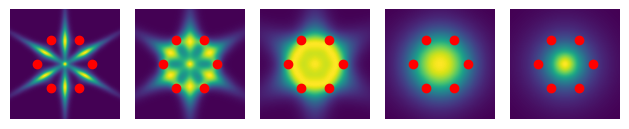

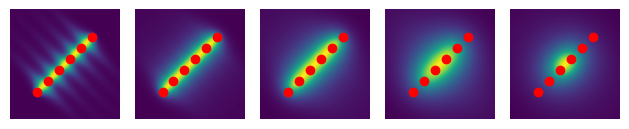

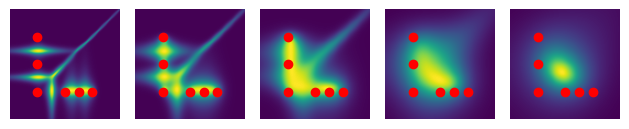

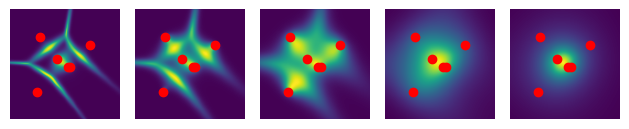

In [27]:
t = np.array([0.05, 0.1, 0.2, 0.5, 0.75])

# polygon
M = 6
m_ = np.arange(M)
mu_x = np.cos(2*np.pi*m_/M)
mu_y = np.sin(2*np.pi*m_/M)
get_frac(mu_x, mu_y, t, name='polygon')


# line
M = 6
mu_x = np.linspace(-1, 1, M)
mu_y = np.linspace(-1, 1, M)
get_frac(mu_x, mu_y, t, name='line')


# axis
M = 6
mu_x = np.array([-1, -1, -1, 0, 0.5, 1])
mu_y = np.array([-1, 0, 1, -1,-1,-1])
get_frac(mu_x, mu_y, t, name='blend')


# random
M = 6
mu_x = np.array([-1, -0.9, -0.3, 0.1, 0.2, 0.9])
mu_y = np.array([-1, 1, 0.2, -0.1, -0.1, 0.7])
get_frac(mu_x, mu_y, t, name='random')